# Overview

This notebook provides an overview of applying Howso Engine to make predictions based on historical data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on vehicle data. We train Howso Engine to predict classes of vehicles, understand potential anomalies, investigate vehicles on a case-by-case basis, and review the data that contributed to the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

from howso import engine
from howso.utilities import infer_feature_attributes

# Supervised ML

## 1. Load Data

The last column, vehicle class, is our target variable. We'll use the other variables (with the exception of make and model, as this would be too easy) to build a model. 

In [2]:
df = pd.read_csv('data/vehicle_processed.csv')

# drop any duplicate records
df = df.drop_duplicates()

# keep a copy of the original data for later reference Make & Model
df_original = df.copy()

df = df.drop(['Make', 'Model'], axis=1)
df

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
0,23,Front-Wheel Drive,Regular,33,1985,77,19,Subcompact Cars
1,17,4-Wheel or All-Wheel Drive,Premium,23,1993,90,14,Compact Cars
2,21,Front-Wheel Drive,Regular,24,1993,88,15,Compact Cars
3,22,Front-Wheel Drive,Regular,29,1993,88,15,Compact Cars
4,23,Front-Wheel Drive,Regular,26,1993,89,13,Compact Cars
...,...,...,...,...,...,...,...,...
23600,21,Front-Wheel Drive,Regular,32,1993,89,12,Compact Cars
23601,19,Front-Wheel Drive,Regular,26,1993,90,14,Compact Cars
23602,20,Front-Wheel Drive,Regular,28,1993,90,14,Compact Cars
23603,18,4-Wheel or All-Wheel Drive,Regular,24,1993,90,14,Compact Cars


NOTE: Howso Engine can work with missing values natively

In [3]:
df.isnull().sum()

CityMPG              0
DriveType          783
FuelType             0
HighwayMPG           0
Year                 0
PassengerVolume      0
LuggageVolume        0
VehicleClass         0
dtype: int64

In [4]:
df[df.DriveType.isnull()]

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
9707,15,NaN,Regular,20,1984,50,22,Two Seaters
9708,16,NaN,Regular,20,1984,50,22,Two Seaters
9709,16,NaN,Regular,22,1984,50,22,Two Seaters
9710,18,NaN,Regular,24,1984,50,22,Two Seaters
9711,17,NaN,Regular,24,1984,74,7,Minicompact Cars
...,...,...,...,...,...,...,...,...
10848,14,NaN,Regular,19,1984,110,50,Midsize-Large Station Wagons
10849,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10850,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10851,13,NaN,Regular,20,1984,110,50,Midsize-Large Station Wagons


In [5]:
labels = df['VehicleClass'].unique()
list(labels)

['Subcompact Cars',
 'Compact Cars',
 'Midsize Cars',
 'Large Cars',
 'Small Station Wagons',
 'Midsize-Large Station Wagons',
 'Minicompact Cars',
 'Two Seaters',
 'Midsize Station Wagons',
 'Special Purpose Vehicle 4WD',
 'Sport Utility Vehicle - 4WD',
 'Sport Utility Vehicle - 2WD',
 'Small Pickup Trucks 4WD',
 'Small Sport Utility Vehicle 4WD',
 'Small Sport Utility Vehicle 2WD',
 'Special Purpose Vehicle 2WD',
 'Standard Sport Utility Vehicle 2WD',
 'Standard Sport Utility Vehicle 4WD']

## 2. Train model

For the purpose of this demo we will use the older cars in the dataset to predict newer cars.

In [6]:
test_index = df[df['Year'].isin([2021])].index
train_index = df[~df['Year'].isin([2021])].index

# train & test size
print("train size (ratio): " + str(round(len(train_index) / df.shape[0], 2) ))
print("test size (ratio): " + str(round(len(test_index) / df.shape[0], 2) ) )

train size (ratio): 0.97
test size (ratio): 0.03


In [7]:
df_train = df.loc[train_index, :]
X_test = df.loc[test_index, :].drop('VehicleClass', axis=1)
y_test = df.loc[test_index, 'VehicleClass']

In [8]:
# explicitly specify continuous features
custom_features = {}

cont_features = ['CityMPG', 'HighwayMPG', 'PassengerVolume', 'LuggageVolume', 'Year']

for ft in cont_features:
    custom_features[ft] = {'type': 'continuous'}

# infer features using dataframe format
features = infer_feature_attributes(df, features=custom_features)

pprint(features, indent=2)

{ 'CityMPG': { 'bounds': {'allow_null': False},
               'data_type': 'number',
               'decimal_places': 0,
               'original_type': {'data_type': 'integer', 'size': 8},
               'type': 'continuous'},
  'DriveType': {'original_type': {'data_type': 'string'}, 'type': 'nominal'},
  'FuelType': {'original_type': {'data_type': 'string'}, 'type': 'nominal'},
  'HighwayMPG': { 'bounds': {'allow_null': False},
                  'data_type': 'number',
                  'decimal_places': 0,
                  'original_type': {'data_type': 'integer', 'size': 8},
                  'type': 'continuous'},
  'LuggageVolume': { 'bounds': {'allow_null': False},
                     'data_type': 'number',
                     'decimal_places': 0,
                     'original_type': {'data_type': 'integer', 'size': 8},
                     'type': 'continuous'},
  'PassengerVolume': { 'bounds': {'allow_null': False},
                       'data_type': 'number',
           

In [9]:
# specify context and action features
context_features = features.get_names(without=['VehicleClass'])
action_features = ['VehicleClass']

# create the trainee
t = engine.Trainee(name='Engine - Car Type Recipe', 
                    features=features, 
                    overwrite_existing=True)

# train the trainee
t.train(df_train)

# analyze
t.analyze()

## 3. Predict

In [10]:
results = t.react(X_test, action_features=action_features, context_features=context_features)
predictions = results['action']['VehicleClass']

In [11]:
accuracy_score = accuracy_score(y_test, predictions).round(3)
print(accuracy_score)

0.919


How accurately can we predict vehicle classes?

In [12]:
score = f1_score(y_test, predictions, average=None)

In [13]:
for i in range(0, len(set(y_test))): 
    print(labels[i] + ': ' + str(score[i].round(3)))

Subcompact Cars: 0.912
Compact Cars: 0.877
Midsize Cars: 0.919
Large Cars: 0.909
Small Station Wagons: 0.986
Midsize-Large Station Wagons: 1.0
Minicompact Cars: 0.842
Two Seaters: 0.786
Midsize Station Wagons: 1.0
Special Purpose Vehicle 4WD: 1.0
Sport Utility Vehicle - 4WD: 0.97


For some vehicle classes we don't have much data and perform poorly. However for classes for which we have sufficient data we are able to make good predictions. Let's investigate a car at random from the full data set and see what we can learn about it.

# Explainable AI

## 1. Understanding the model

In [14]:
t.react_into_features(familiarity_conviction_addition=True)
stored_convictions = t.get_cases(session=t.active_session, features=['familiarity_conviction_addition','.session_training_index', '.session'])

In [15]:
convict_df = df_original.loc[train_index].reset_index(drop=True).join(stored_convictions).rename(columns={'familiarity_conviction_addition':'convictions'})
convict_df.sort_values('convictions').head()

,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
12462,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2013,72,14,Subcompact Cars,0.000785,12462,768f5d53-a357-477e-91b5-c2f272e906c2
11727,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2012,72,14,Subcompact Cars,0.000818,11727,768f5d53-a357-477e-91b5-c2f272e906c2
19362,28,Front-Wheel Drive,Diesel,35,Volkswagen,Quantum Wagon,1985,91,38,Small Station Wagons,0.001916,19362,768f5d53-a357-477e-91b5-c2f272e906c2
12399,132,Front-Wheel Drive,Electricity,105,Honda,Fit EV,2013,91,21,Small Station Wagons,0.006032,12399,768f5d53-a357-477e-91b5-c2f272e906c2
11654,106,Front-Wheel Drive,Electricity,92,Nissan,Leaf,2012,90,23,Midsize Cars,0.007620,11654,768f5d53-a357-477e-91b5-c2f272e906c2


In [16]:
convict_df.sort_values('convictions', ascending=False).head()

,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
7653,10,Rear-Wheel Drive,Premium,14,Bentley,Arnage LWB,2007,111,13,Large Cars,111749.239995,7653,768f5d53-a357-477e-91b5-c2f272e906c2
16766,28,Front-Wheel Drive,Diesel,39,GMC,Terrain FWD,2019,90,13,Small Sport Utility Vehicle 2WD,11785.086590,16766,768f5d53-a357-477e-91b5-c2f272e906c2
4524,19,4-Wheel or All-Wheel Drive,Regular,25,Subaru,Forester AWD,2002,94,32,Sport Utility Vehicle - 4WD,7422.812871,4524,768f5d53-a357-477e-91b5-c2f272e906c2
13466,21,All-Wheel Drive,Premium,32,BMW,428i xDrive Convertible,2014,88,10,Subcompact Cars,7030.485695,13466,768f5d53-a357-477e-91b5-c2f272e906c2
19957,14,Rear-Wheel Drive,Regular,21,Porsche,Carrera,1991,55,4,Two Seaters,6455.675600,19957,768f5d53-a357-477e-91b5-c2f272e906c2


## 2. Investigate a single vehicle

In [17]:
# investigate the Kia K900 as an example
k900 = convict_df[(convict_df.Model=='K900') & (convict_df.Year==2015)].iloc[0, :]
k900_case_indices = [(k900['.session'], k900['.session_training_index'])]
k900

CityMPG                                                      18
DriveType                                      Rear-Wheel Drive
FuelType                                                Regular
HighwayMPG                                                   26
Make                                                        Kia
Model                                                      K900
Year                                                       2015
PassengerVolume                                             110
LuggageVolume                                                16
VehicleClass                                         Large Cars
convictions                                            8.573098
.session_training_index                                   13336
.session                   768f5d53-a357-477e-91b5-c2f272e906c2
Name: 13336, dtype: object

<img src="data/K900_overview.png" width="320">

Howso Engine's power is in its interpretability. Let's see what the model can tell us about this car.

In [18]:
details = {'most_similar_cases': True, 
           'num_most_similar_cases': 30, 
           'boundary_cases': True, 
           'num_boundary_cases': 30, 
           'influential_cases': True,
           'robust_computation': True,
           'feature_mda': True, 
           'feature_residuals': True}

new_result = t.react(case_indices=k900_case_indices, 
                     action_features=action_features, 
                     preserve_feature_values=context_features, 
                     leave_case_out=True, details=details)

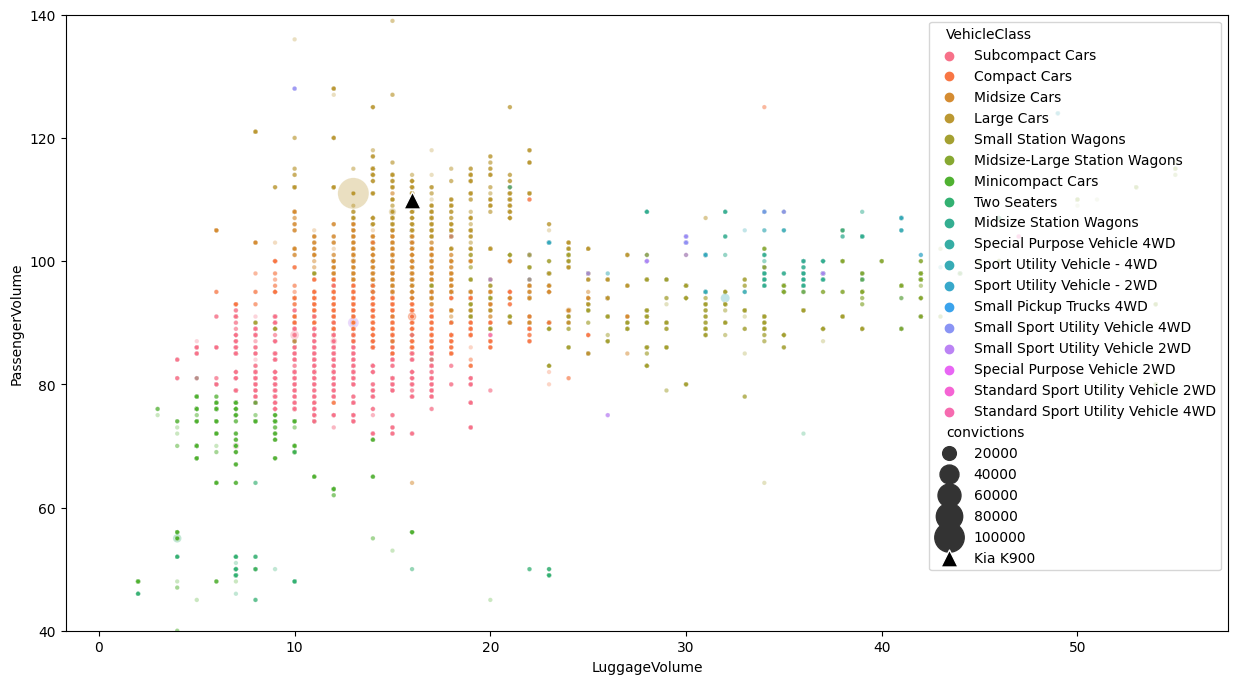

In [19]:
make = 'Kia K900'

fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(ax=ax, data=convict_df, x='LuggageVolume', y= 'PassengerVolume', 
                size='convictions', sizes=(10, 500), hue='VehicleClass', alpha=0.3)

sns.scatterplot(ax=ax, data=pd.DataFrame(k900).T, 
                x='LuggageVolume', y= 'PassengerVolume', 
                c=['black'], s=150, marker='^', 
                label=make)

ax.set(ylim=(40, 140))

plt.show()

In [20]:
new_result['action']['VehicleClass'][0]

'Large Cars'

In [21]:
list(new_result['explanation'].keys())

['context_values',
 'boundary_cases',
 'influential_cases',
 'most_similar_cases',
 'feature_residuals',
 'feature_mda',
 'action_features']

There is a LOT of information here, a few interesting bits:

1. Action value: This is the vehicle type
2. Most similar cases: These observations are a lot similar to our chosen car.
3. Boundary cases: These are observations on the 'edge' of being labeled with the class. This is our decision boundary.

## 3. Most similar cases / Boundary cases

In [22]:
most_similar_df = pd.DataFrame(new_result['explanation']['influential_cases'][0]).drop('VehicleClass', axis=1)

most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

most_similar_records = most_similar_records.loc[ : , cols_order]
most_similar_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,0.236919,768f5d53-a357-477e-91b5-c2f272e906c2,10029,Dodge,Charger,2010,18,16,Regular,26,104,Rear-Wheel Drive,Large Cars
1,0.216543,768f5d53-a357-477e-91b5-c2f272e906c2,8746,Dodge,Charger,2009,18,16,Regular,26,104,Rear-Wheel Drive,Large Cars
2,0.200558,768f5d53-a357-477e-91b5-c2f272e906c2,8183,Dodge,Charger,2008,18,16,Regular,26,104,Rear-Wheel Drive,Large Cars
3,0.193188,768f5d53-a357-477e-91b5-c2f272e906c2,13676,Porsche,Panamera S,2015,18,16,Premium,26,108,Rear-Wheel Drive,Large Cars
4,0.110112,768f5d53-a357-477e-91b5-c2f272e906c2,13741,Chevrolet,Camaro,2015,18,11,Regular,26,93,Rear-Wheel Drive,Compact Cars
5,0.017750,768f5d53-a357-477e-91b5-c2f272e906c2,13273,Hyundai,Genesis,2014,18,16,Regular,27,109,Rear-Wheel Drive,Large Cars
6,0.013851,768f5d53-a357-477e-91b5-c2f272e906c2,14482,Kia,K900,2016,17,16,Regular,25,110,Rear-Wheel Drive,Large Cars
7,0.011079,768f5d53-a357-477e-91b5-c2f272e906c2,15110,Kia,K900,2017,17,16,Regular,25,110,Rear-Wheel Drive,Large Cars


<img src="data/Firstgen_K9.png" width="1080">

In [23]:
boundary_case_df = pd.DataFrame(new_result['explanation']['boundary_cases'][0]).drop('VehicleClass', axis=1)

boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

boundary_records = boundary_records.loc[ : , cols_order]
boundary_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,6889,Nissan,Maxima,2006,18,16,Regular,26,104,Front-Wheel Drive,Midsize Cars
1,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8138,Cadillac,CTS,2008,18,14,Regular,26,96,Rear-Wheel Drive,Midsize Cars
2,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8484,Cadillac,CTS,2009,18,14,Regular,26,97,Rear-Wheel Drive,Midsize Cars
3,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8501,Ford,Fusion FWD,2009,18,16,Regular,26,101,Front-Wheel Drive,Midsize Cars
4,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8501,Mercury,Milan,2009,18,16,Regular,26,101,Front-Wheel Drive,Midsize Cars
5,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8508,Ford,Fusion FWD,2009,18,16,Regular,26,101,Front-Wheel Drive,Midsize Cars
6,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8508,Mercury,Milan,2009,18,16,Regular,26,101,Front-Wheel Drive,Midsize Cars
7,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8856,Ford,Mustang,2010,18,13,Regular,26,85,Rear-Wheel Drive,Subcompact Cars
8,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,8895,Cadillac,CTS,2010,18,16,Regular,27,100,Rear-Wheel Drive,Midsize Cars
9,0.0,768f5d53-a357-477e-91b5-c2f272e906c2,10118,Cadillac,CTS AWD,2010,18,16,Regular,26,100,All-Wheel Drive,Midsize Cars


Notice how similar the boundary case are to the chosen example (Kia K900), with the exception of the 'VehicleClass'. Also, the influence_weight are all '0' in this case indicating the case of interest does not lie on the boundary.

Let's plot and identify a similar and an edge case. Keep in mind we are only visualizing 2 of the 6 predictor variables. Therefore similar and boundary cases may not be right next to, or exactly on a class boundary, in the following plots.

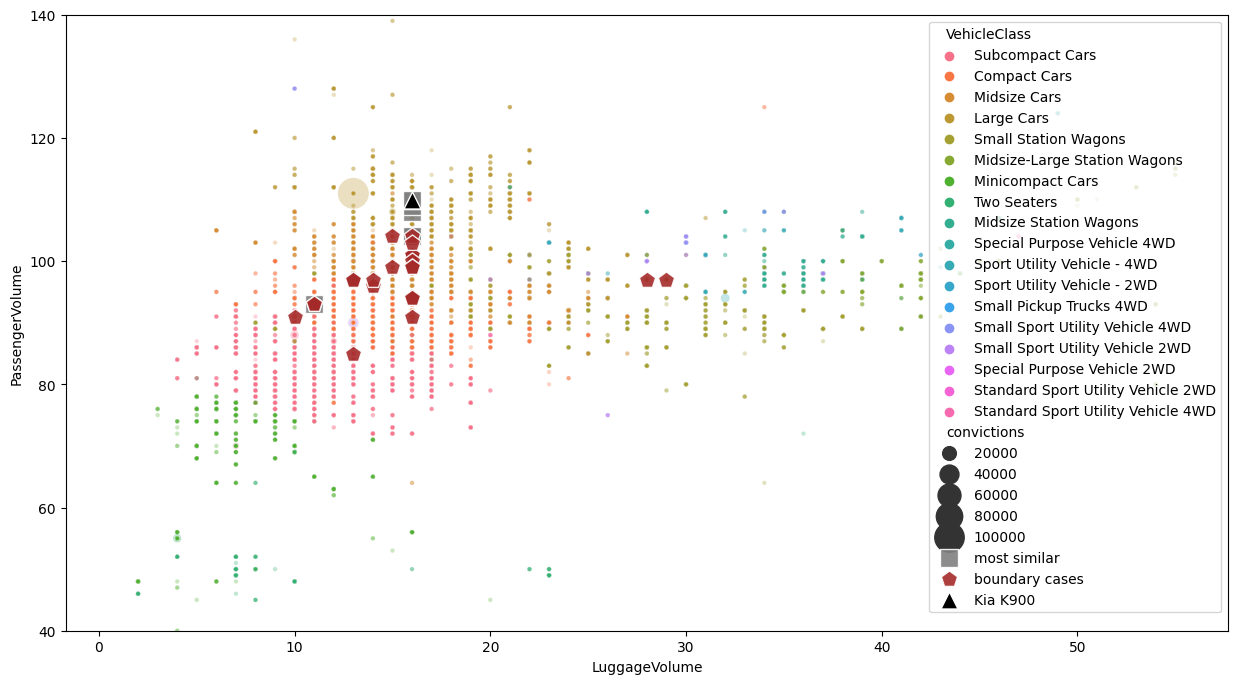

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(ax=ax, data=convict_df, x='LuggageVolume', y= 'PassengerVolume', 
                size='convictions', sizes=(10, 500), hue='VehicleClass', alpha=0.3)

sns.scatterplot(ax=ax, data=most_similar_df, x='LuggageVolume', y= 'PassengerVolume', c=['grey'],
                s=150, marker=',', alpha=0.9, label='most similar')

sns.scatterplot(ax=ax, data=boundary_case_df, x='LuggageVolume', y= 'PassengerVolume', c=['brown'],
                s=150, marker='p', alpha=0.9, label='boundary cases')

sns.scatterplot(ax=ax, data=pd.DataFrame(k900).T, 
                x='LuggageVolume', y= 'PassengerVolume', 
                c=['black'], s=150, marker='^', 
                label=make)

ax.set(ylim=(40, 140))

plt.show()

## 4. Feature relevancy metrics

Check the mean decrease in accuracy for the local model around the prediction:

In [25]:
new_result['explanation']['feature_mda'][0]

{'CityMPG': 0.012760416666666635,
 'LuggageVolume': 0.1318080357142857,
 'FuelType': 0.11259920634920625,
 'HighwayMPG': 0.15874711995443178,
 'Year': -0.003162202380952328,
 'PassengerVolume': 0.18685338718820851,
 'DriveType': 0.002120535714285693}

As observed from the 'most similar' and 'boundary' cases above, we can see that there were many vehicles which were similar to each other in that space. With the 'LuggageVolume' being a critical feature in distinguishing the VehicleClass in that region.

NOTE: the mda (mean decrease in accuracy) measures are approximations of the SHAP value.

Another informative comparison is to check the local residuals against the global residuals to understand the uncertainty and predictability of the features. 

In [26]:
feature_residuals_dicts = new_result['explanation']['feature_residuals']
feature_residuals = pd.DataFrame(list(feature_residuals_dicts[0].items()))
feature_residuals = feature_residuals.T
feature_residuals.columns = feature_residuals.loc[0]
feature_residuals = feature_residuals.drop(0, axis=0)
feature_residuals

,CityMPG,LuggageVolume,FuelType,HighwayMPG,Year,VehicleClass,PassengerVolume,DriveType
1,1.262242,1.882014,0.466259,1.521194,8.101151,0.480416,6.911923,0.669538


In [27]:
t.react_into_trainee(residuals=True)
t.get_prediction_stats(stats=['mae'])

,CityMPG,LuggageVolume,FuelType,HighwayMPG,Year,VehicleClass,PassengerVolume,DriveType
mae,2.084485,3.246908,0.257826,2.366713,5.208701,0.367048,4.355996,0.292569


The ‘Year’ feature jumps out in the above comparison – in the global residual the MAE was approximately 2, but in the localized region the MAE is much higher.

This is perhaps not a big surprise considering the cases we chose to investigate (Kia K900) which was a luxury car, which generally will have less variation year over year hence the ‘Year’ feature has less predictive power.


## 5. Low and high conviction comparisons

In [28]:
# helper function to extract out most similar and boundary cases
def get_info(case):
    details = {'most_similar_cases': True, 
               'num_most_similar_cases': 10, 
               'boundary_cases': True, 
               'num_boundary_cases': 10, 
               'influential_cases': True}
    
    new_result = t.react(case_indices=case, preserve_feature_values=context_features, leave_case_out=True, 
                         details=details, action_features=action_features)
    
    print('')   
    most_similar_df = pd.DataFrame(new_result['explanation']['influential_cases'][0]).drop('VehicleClass', axis=1)

    most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    most_similar_records = most_similar_records.loc[ : , cols_order]

    print('Similar cases:')
    display(most_similar_records)
    
    boundary_case_df = pd.DataFrame(new_result['explanation']['boundary_cases'][0]).drop('VehicleClass', axis=1)

    boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    boundary_records = boundary_records.loc[ : , cols_order]
    print('Boundary cases:')
    display(boundary_records)

In [29]:
# pick a record from high / low conviction region
low_convict_record = convict_df.sort_values('convictions', ascending=True).iloc[0, :]
low_convict_case_index = [(low_convict_record['.session'], low_convict_record['.session_training_index'])]

high_convict_record = convict_df.sort_values('convictions', ascending=False).iloc[0, :]
high_convict_case_index = [(high_convict_record['.session'], high_convict_record['.session_training_index'])]

In [30]:
# low conviction record
low_convict_record

CityMPG                                                      77
DriveType                                     Front-Wheel Drive
FuelType                                            Electricity
HighwayMPG                                                   68
Make                                            CODA Automotive
Model                                                      CODA
Year                                                       2013
PassengerVolume                                              72
LuggageVolume                                                14
VehicleClass                                    Subcompact Cars
convictions                                            0.000785
.session_training_index                                   12462
.session                   768f5d53-a357-477e-91b5-c2f272e906c2
Name: 12462, dtype: object

In [31]:
get_info(low_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,0.999999,768f5d53-a357-477e-91b5-c2f272e906c2,11727,CODA Automotive,CODA,2012,77,14,Electricity,68,72,Front-Wheel Drive,Subcompact Cars


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,4.411461e-08,768f5d53-a357-477e-91b5-c2f272e906c2,11728,Ford,Focus Electric,2012,110,14,Electricity,99,90,Front-Wheel Drive,Compact Cars
1,3.364112e-07,768f5d53-a357-477e-91b5-c2f272e906c2,12246,Ford,Focus Electric,2013,110,14,Electricity,99,90,Front-Wheel Drive,Compact Cars
2,0.000000e+00,768f5d53-a357-477e-91b5-c2f272e906c2,12433,Scion,iQ EV,2013,138,4,Electricity,105,73,Front-Wheel Drive,Minicompact Cars
3,4.411461e-08,768f5d53-a357-477e-91b5-c2f272e906c2,12999,Ford,Focus Electric,2014,110,14,Electricity,99,90,Front-Wheel Drive,Compact Cars
4,4.389320e-08,768f5d53-a357-477e-91b5-c2f272e906c2,13184,Fiat,500e,2014,122,7,Electricity,108,72,Front-Wheel Drive,Minicompact Cars
5,3.850291e-08,768f5d53-a357-477e-91b5-c2f272e906c2,13730,Fiat,500e,2015,122,7,Electricity,108,72,Front-Wheel Drive,Minicompact Cars
6,3.869460e-08,768f5d53-a357-477e-91b5-c2f272e906c2,14217,Ford,Focus Electric,2015,110,14,Electricity,99,90,Front-Wheel Drive,Compact Cars
7,0.000000e+00,768f5d53-a357-477e-91b5-c2f272e906c2,14813,Ford,Focus Electric,2016,110,14,Electricity,99,91,Front-Wheel Drive,Compact Cars
8,3.713420e-08,768f5d53-a357-477e-91b5-c2f272e906c2,14905,Fiat,500e,2016,121,7,Electricity,103,72,Front-Wheel Drive,Minicompact Cars
9,0.000000e+00,768f5d53-a357-477e-91b5-c2f272e906c2,15242,Fiat,500e,2017,121,7,Electricity,103,72,Front-Wheel Drive,Minicompact Cars


In [32]:
# high conviction record
high_convict_record

CityMPG                                                      10
DriveType                                      Rear-Wheel Drive
FuelType                                                Premium
HighwayMPG                                                   14
Make                                                    Bentley
Model                                                Arnage LWB
Year                                                       2007
PassengerVolume                                             111
LuggageVolume                                                13
VehicleClass                                         Large Cars
convictions                                       111749.239995
.session_training_index                                    7653
.session                   768f5d53-a357-477e-91b5-c2f272e906c2
Name: 7653, dtype: object

In [33]:
get_info(high_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,0.462919,768f5d53-a357-477e-91b5-c2f272e906c2,8362,Bentley,Arnage,2009,10,13,Premium,14,104,Rear-Wheel Drive,Midsize Cars
1,0.442755,768f5d53-a357-477e-91b5-c2f272e906c2,7614,Bentley,Arnage,2007,10,13,Premium,15,104,Rear-Wheel Drive,Midsize Cars
2,0.018936,768f5d53-a357-477e-91b5-c2f272e906c2,6910,Bentley,Arnage LWB,2006,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
3,0.018936,768f5d53-a357-477e-91b5-c2f272e906c2,8006,Bentley,Arnage RL,2008,9,13,Premium,15,111,Rear-Wheel Drive,Large Cars
4,0.015146,768f5d53-a357-477e-91b5-c2f272e906c2,6265,Bentley,Arnage LWB,2005,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
5,0.015146,768f5d53-a357-477e-91b5-c2f272e906c2,8373,Bentley,Arnage RL,2009,9,13,Premium,15,111,Rear-Wheel Drive,Large Cars
6,0.013226,768f5d53-a357-477e-91b5-c2f272e906c2,5599,Bentley,Arnage LWB,2004,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
7,0.012936,768f5d53-a357-477e-91b5-c2f272e906c2,7695,Maybach,57,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars
8,0.012936,768f5d53-a357-477e-91b5-c2f272e906c2,7695,Maybach,57S,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,CityMPG,LuggageVolume,FuelType,HighwayMPG,PassengerVolume,DriveType,VehicleClass
0,0.000000,768f5d53-a357-477e-91b5-c2f272e906c2,4940,Bentley,Arnage LWB,2003,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
1,0.013226,768f5d53-a357-477e-91b5-c2f272e906c2,5599,Bentley,Arnage LWB,2004,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
2,0.015146,768f5d53-a357-477e-91b5-c2f272e906c2,6265,Bentley,Arnage LWB,2005,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
3,0.018936,768f5d53-a357-477e-91b5-c2f272e906c2,6910,Bentley,Arnage LWB,2006,9,13,Premium,13,111,Rear-Wheel Drive,Large Cars
4,0.000000,768f5d53-a357-477e-91b5-c2f272e906c2,7653,Bentley,Arnage LWB,2007,10,13,Premium,14,111,Rear-Wheel Drive,Large Cars
5,0.012936,768f5d53-a357-477e-91b5-c2f272e906c2,7695,Maybach,57,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars
6,0.012936,768f5d53-a357-477e-91b5-c2f272e906c2,7695,Maybach,57S,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars
7,0.000000,768f5d53-a357-477e-91b5-c2f272e906c2,7696,Maybach,57,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars
8,0.000000,768f5d53-a357-477e-91b5-c2f272e906c2,7696,Maybach,57S,2007,10,15,Premium,16,112,Rear-Wheel Drive,Large Cars
9,0.000000,768f5d53-a357-477e-91b5-c2f272e906c2,7697,Maybach,62,2007,10,15,Premium,16,114,Rear-Wheel Drive,Large Cars
